# 🔁Continuous Feedback Loop for Cybersecurity AI

In [2]:
!pip install kagglehub shap lime xgboost scikit-learn pandas matplotlib psycopg2-binary --quiet
import os
import csv
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from xgboost import XGBRegressor
from lime.lime_tabular import LimeTabularExplainer
import kagglehub

# Configuration

In [3]:
MODEL_DIR       = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
BEST_REG_MODEL  = os.path.join(MODEL_DIR, 'best_regressor.joblib')
SCALER_FILE     = os.path.join(MODEL_DIR, 'scaler.joblib')
ENCODERS_FILE   = os.path.join(MODEL_DIR, 'encoders.joblib')
ANOMALY_MODEL   = os.path.join(MODEL_DIR, 'iso_forest.joblib')
FEEDBACK_LOG    = 'regression_feedback.csv'
RETRAIN_THRESHOLD = 5

#Load & Preprocess Data

Anomaly model trained on numeric features
Linear → MSE: 811.64
RF → MSE: 878.73
GB → MSE: 825.79
XGB → MSE: 1052.43
Best regressor (Linear) saved.

--- AI Explainability with SHAP and LIME ---

Generating SHAP explanations...


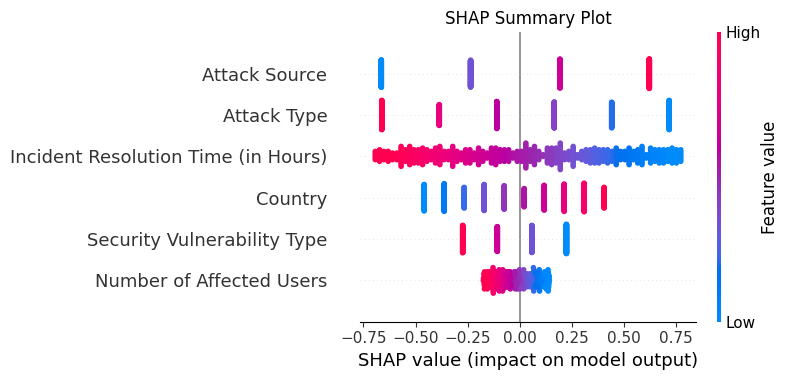

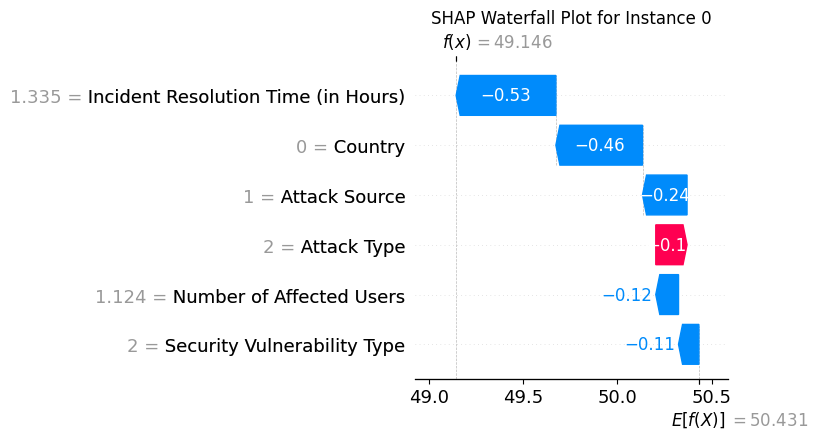


Generating LIME explanations...


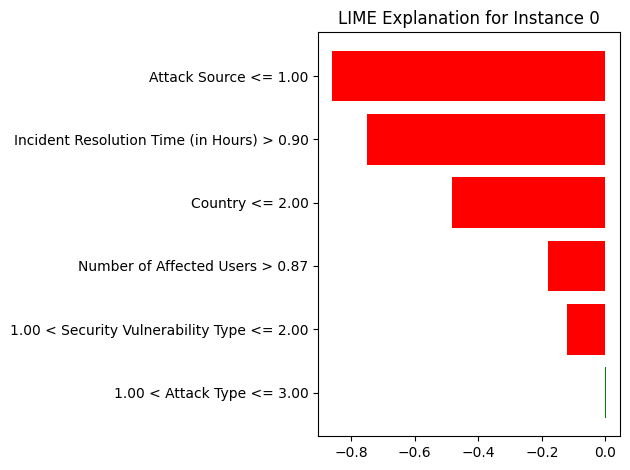


--- Simulating Prediction and Feedback Logging ---
Feedback logged for all test instances.

--- Checking for Retraining ---
Feedback threshold met: 600 entries. Retraining...
Model retrained and feedback log cleared.

--- Notebook Execution Complete ---


In [4]:
def load_and_preprocess():
    # Load dataset or fallback dummy
    try:
        path = kagglehub.dataset_download('atharvasoundankar/global-cybersecurity-threats-2015-2024')
        file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
        df = pd.read_csv(os.path.join(path, file))
    except Exception as e:
        print(f'Error loading Kaggle dataset: {e}. Using dummy data.')
        df = pd.DataFrame({
            'Financial Loss (in Million $)': np.random.rand(200)*100,
            'Number of Affected Users': np.random.randint(1,5000,200),
            'Incident Resolution Time (in Hours)': np.random.rand(200)*72,
            'Country': np.random.choice(['India','USA','UK','Germany'],200),
            'Attack Type': np.random.choice(['Phishing','Malware','DDoS'],200),
            'Attack Source': np.random.choice(['External','Internal'],200),
            'Security Vulnerability Type': np.random.choice(['Bug','Misconfig','Zero-Day'],200)
        })
    # Select features
    cols = ['Financial Loss (in Million $)', 'Number of Affected Users',
            'Incident Resolution Time (in Hours)', 'Country', 'Attack Type',
            'Attack Source', 'Security Vulnerability Type']
    data = df[cols].copy()

    # Encode categoricals
    encoders = {}
    for c in ['Country','Attack Type','Attack Source','Security Vulnerability Type']:
        le = LabelEncoder()
        data[c] = le.fit_transform(data[c])
        encoders[c] = le

    # Split features and target BEFORE scaling
    X = data.drop('Financial Loss (in Million $)', axis=1)
    y = data['Financial Loss (in Million $)']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

    # Scale numeric features ONLY
    nums = ['Number of Affected Users','Incident Resolution Time (in Hours)']
    scaler = StandardScaler().fit(X_train[nums])
    X_train[nums] = scaler.transform(X_train[nums])
    X_test[nums]  = scaler.transform(X_test[nums])

    # Save artifacts
    joblib.dump(scaler, SCALER_FILE)
    joblib.dump(encoders, ENCODERS_FILE)
    return X_train, X_test, y_train, y_test, encoders, scaler

X_train, X_test, y_train, y_test, encoders, scaler = load_and_preprocess()

# --- Train Anomaly Model on Numeric Only ---
numeric_train = X_train.select_dtypes(include=[np.number])
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(numeric_train)
joblib.dump(iso, ANOMALY_MODEL)
print('Anomaly model trained on numeric features')

# --- Train & Select Best Regression Model ---
def eval_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print(f"{name} → MSE: {mse:.2f}")
    return mse, name, model

candidates = [
    eval_model('Linear', LinearRegression()),
    eval_model('RF', RandomForestRegressor(n_estimators=100,random_state=42)),
    eval_model('GB', GradientBoostingRegressor(random_state=42)),
    eval_model('XGB', XGBRegressor(n_estimators=100,verbosity=0))
]
best_mse, best_name, best_model = sorted(candidates)[0]  # Unpack the best model
joblib.dump(best_model, BEST_REG_MODEL)
print(f'Best regressor ({best_name}) saved.')

# --- Explain with SHAP & LIME ---
print("\n--- AI Explainability with SHAP and LIME ---")

# SHAP Explanation
try:
    print("\nGenerating SHAP explanations...")
    expl = shap.Explainer(best_model, X_train)
    sv = expl(X_test)
    shap.summary_plot(sv, X_test, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()

    if len(sv.data) > 0:
        shap.plots.waterfall(sv[0], show=False)
        plt.title("SHAP Waterfall Plot for Instance 0")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data in X_test for waterfall plot.")
except Exception as e:
    print(f"Error generating SHAP plots: {e}")

# LIME Explanation
print("\nGenerating LIME explanations...")
lime_expl = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression'
)

def lime_predict_wrapper(data_row_array):
    # LIME passes a NumPy array, convert it back to a DataFrame with correct columns
    data_df = pd.DataFrame(data_row_array, columns=X_train.columns)
    return best_model.predict(data_df)

try:
    fig = lime_expl.explain_instance(X_test.iloc[0].values, lime_predict_wrapper).as_pyplot_figure()
    plt.title("LIME Explanation for Instance 0")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error generating LIME plot: {e}")

# --- Feedback Logging Function ---
def log_feedback(entry):
    file_exists = os.path.exists(FEEDBACK_LOG)
    with open(FEEDBACK_LOG,'a',newline='') as f:
        writer = csv.DictWriter(f, fieldnames=entry.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(entry)

# ---Simulate Prediction & Feedback ---
print('\n--- Simulating Prediction and Feedback Logging ---')
best_model_loaded = joblib.load(BEST_REG_MODEL)

for i in range(len(X_test)):
    xi_df = X_test.iloc[[i]]
    pred = best_model_loaded.predict(xi_df)[0]
    actual = y_test.iloc[i]
    xi_dict = xi_df.iloc[0].to_dict()
    log_feedback({**xi_dict, 'pred': pred, 'actual': actual})
print('Feedback logged for all test instances.')

# ---Retrain From Feedback If Ready ---
print('\n--- Checking for Retraining ---')
fb = pd.read_csv(FEEDBACK_LOG)
if len(fb) >= RETRAIN_THRESHOLD:
    print(f"Feedback threshold met: {len(fb)} entries. Retraining...")
    loaded_encoders  = joblib.load(ENCODERS_FILE)
    loaded_scaler    = joblib.load(SCALER_FILE)
    loaded_best_model = joblib.load(BEST_REG_MODEL)

    Xf = fb.drop(columns=['actual','pred'])
    yf = fb['actual']

    # Encode categories
    for c, le in loaded_encoders.items():
        if c in Xf.columns:
            Xf[c] = Xf[c].apply(lambda v: le.transform([v])[0] if v in le.classes_ else 0)

    # Scale numerics
    nums = ['Number of Affected Users','Incident Resolution Time (in Hours)']
    cols_to_scale = [c for c in nums if c in Xf.columns]
    if cols_to_scale:
        Xf[cols_to_scale] = loaded_scaler.transform(Xf[cols_to_scale])

    # Retrain and clear log
    loaded_best_model.fit(Xf, yf)
    joblib.dump(loaded_best_model, BEST_REG_MODEL)
    os.remove(FEEDBACK_LOG)
    print('Model retrained and feedback log cleared.')
else:
    print(f"{len(fb)} entries; need {RETRAIN_THRESHOLD} to retrain.")

print("\n--- Notebook Execution Complete ---")
